### Image Registration using OpenCV

Image registration is a digital image processing technique that helps us align different images of the same scene. For instance, one may click the picture of a book from various angles. Below are a few instances that show the diversity of camera angles.

Now, we may want to “align” a particular image to the same angle as a reference image. In the images above, one may consider the first image to be an “ideal” cover photo, while the second and third images do not serve well for book cover photo purposes. The image registration algorithm helps us align the second and third pictures to the same plane as the first one.

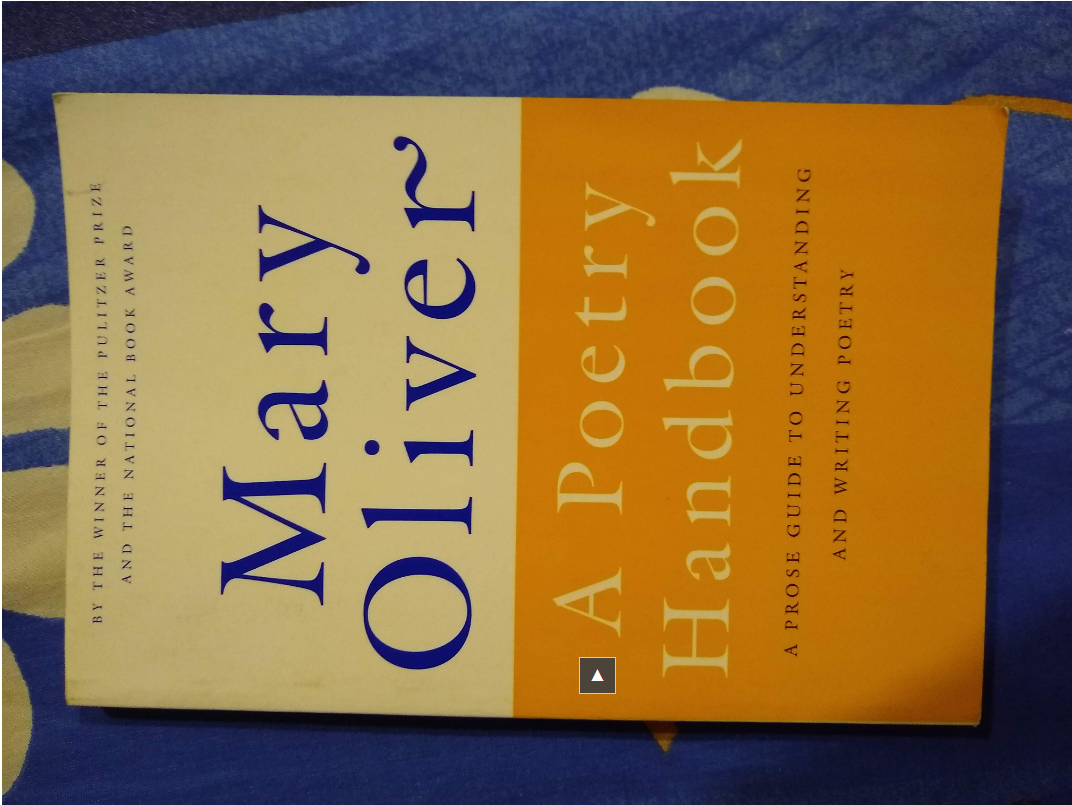

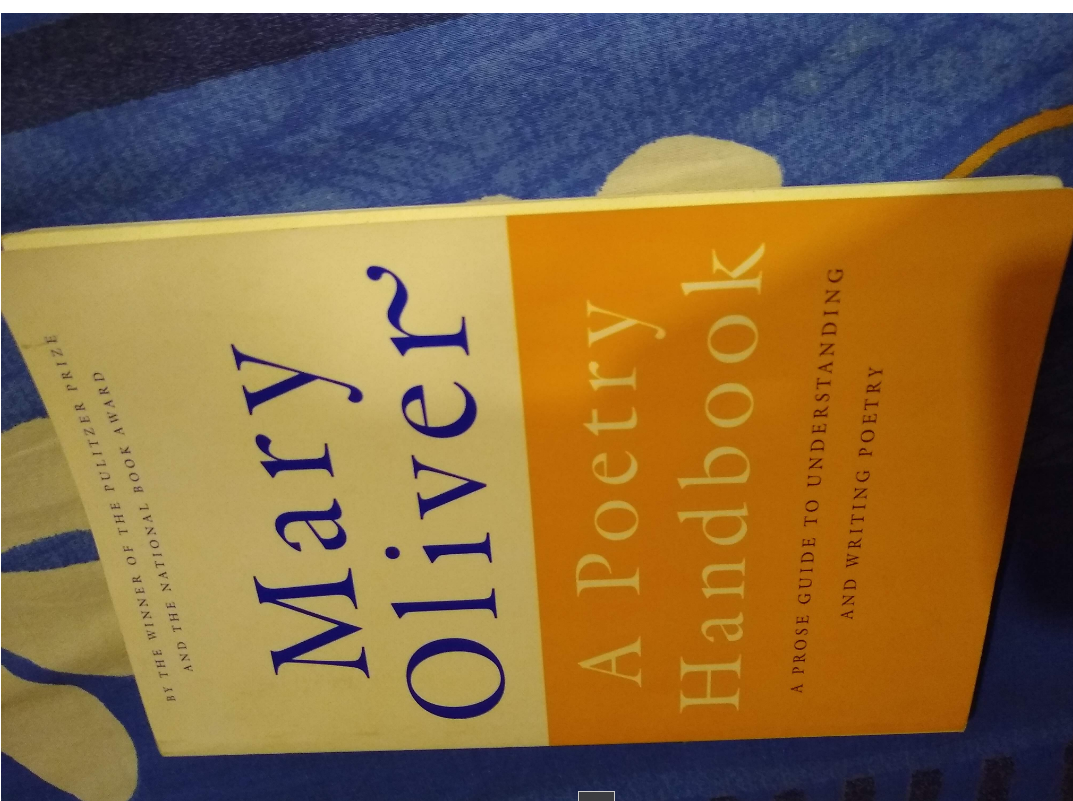

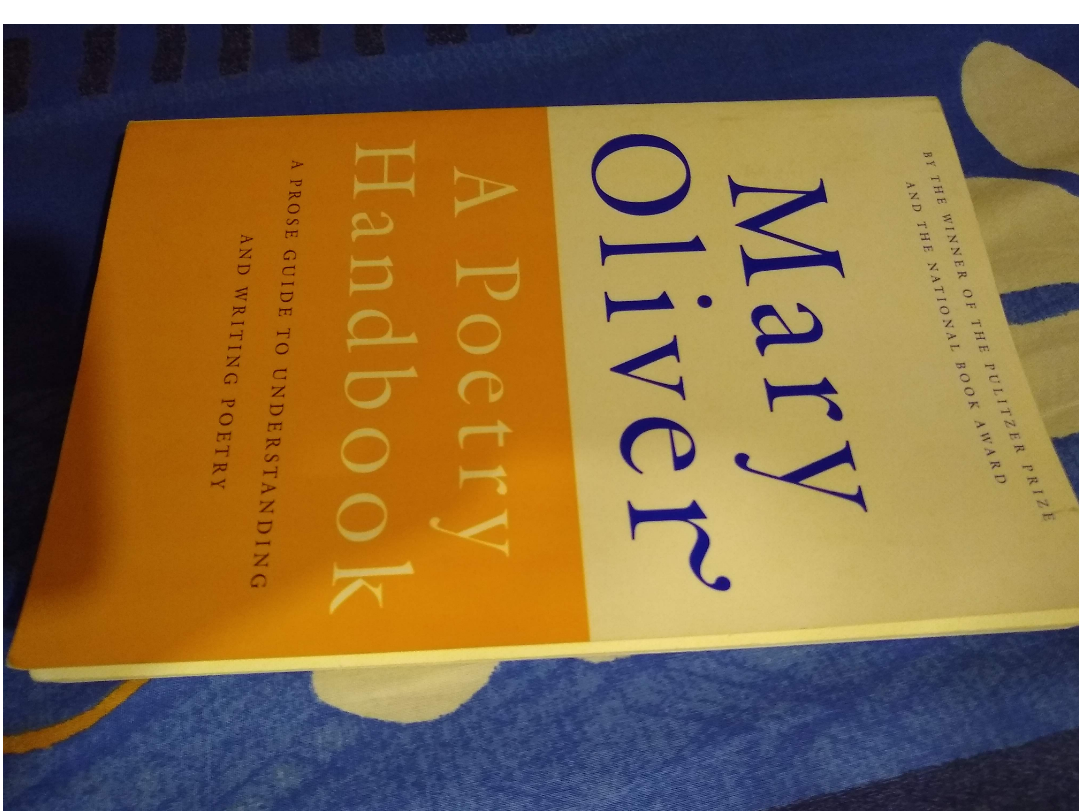

<b>How does image registration work?</b>

Alignment can be looked at as a simple coordinate transform. The algorithm works as follows:

 - Convert both images to grayscale.
 - Match features from the image to be aligned, to the reference image and store the coordinates of the corresponding key points. Keypoints are simply the selected few points that are used to compute the transform (generally points that stand out), and descriptors are histograms of the image gradients to characterize the appearance of a keypoint. In this post, we use ORB (Oriented FAST and Rotated BRIEF) implementation in the OpenCV library, which provides us with both key points as well as their associated descriptors.
 - Match the key points between the two images. In this post, we use BFMatcher, which is a brute force matcher. BFMatcher.match() retrieves the best match, while BFMatcher.knnMatch() retrieves top K matches, where K is specified by the user.
 - Pick the top matches, and remove the noisy matches.
 - Find the homomorphy transform.
 - Apply this transform to the original unaligned image to get the output image.

<b>Applications of Image Registration:</b>

Some of the useful applications of image registration include: 

 - Stitching various scenes (which may or may not have the same camera alignment) together to form a continuous panoramic shot.
 - Aligning camera images of documents to a standard alignment to create realistic scanned documents.
 - Aligning medical images for better observation and analysis.

In [1]:
import cv2
import numpy as np

In [8]:
# read the reference and the image which is to be aligned
reference = cv2.imread("book.jpg", 1)
align = cv2.imread("book1.jpg", 1)

# convert to grayscale
reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)
align = cv2.cvtColor(align, cv2.COLOR_BGR2GRAY)

height, width = reference.shape

# Create ORB detector with 5000 features. 
orb_detector = cv2.ORB_create(5000)

# Find keypoints and descriptors. the first arg is the image, second arg is the mask (which is not required in this case). 
kp1, d1 = orb_detector.detectAndCompute(align, None) 
kp2, d2 = orb_detector.detectAndCompute(reference, None)

# Match features between the two images. We create a Brute Force matcher with Hamming distance as measurement mode. 
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Match the two sets of descriptors. 
matches = matcher.match(d1, d2)

# Sort matches on the basis of their Hamming distance. 
sorted(matches, key = lambda x: x.distance)

# Take the top 90 % matches forward. 
matches = matches[:int(len(matches)*0.9)] 
no_of_matches = len(matches)

# Define empty matrices of shape no_of_matches * 2. 
p1 = np.zeros((no_of_matches, 2)) 
p2 = np.zeros((no_of_matches, 2))

for i in range(len(matches)): 
  p1[i, :] = kp1[matches[i].queryIdx].pt 
  p2[i, :] = kp2[matches[i].trainIdx].pt
  
# Find the homography matrix. 
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

# Use this matrix to transform the colored image wrt the reference image. 
transformed_img = cv2.warpPerspective(align, homography, (width, height))

# display the image
cv2.imshow("transformed_img", transformed_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the output. 
cv2.imwrite('aligned.jpg', transformed_img)

True